<a href="https://colab.research.google.com/github/duke-sunshine/Algorithmic-Trading/blob/main/Session_2_VWAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Import Data

1.   Install the Alpha Vantage API
2.   [Claim your own API Key](https://www.alphavantage.co/support/#api-key)
3.   [Import data from Time Series Stock APIs by specifiying API key and Parameters](https://www.alphavantage.co/documentation/)



In [ ]:
#Install Alpha Vantage Package

!pip install alpha_vantage

In [ ]:
# Make useful imports

from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.techindicators import TechIndicators
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#Data class

class Data:
  def __init__(self,API_key, symbol, interval):
    self.API_key = API_key
    self.symbol = symbol
    self.interval = interval
  def import_data(self):
    ts = TimeSeries(key=self.API_key, output_format='pandas')
    data=ts.get_intraday(self.symbol, interval = self.interval, outputsize = 'full') # We use 5-min interval to determine the time when traders make investment decisions.
    data[0].rename(columns={'1. open':'open', '2. high':'high', '3. low':'low', '4. close':'close', '5. volume':'volume'}, inplace = True)
    all_df = data[0]
    num = int(3/5 * all_df.shape[0])
    all_df.sort_index(ascending=True, inplace=True)

    ti = TechIndicators(key=self.API_key, output_format='pandas')
    vwap_data=ti.get_vwap(self.symbol, interval=self.interval)
    vwap_df = vwap_data[0]
    all_df = all_df.merge(vwap_df, how='inner', left_on='date', right_index=True)

    df = all_df.iloc[num:].copy()
    return df

In [ ]:
#return Tesla data
TSLA=Data('RQT8G71H1MTA5YZJ','TSLA','5min')
df_TSLA=TSLA.import_data()
df_TSLA.head()

,open,high,low,close,volume,VWAP
date,,,,,,
2021-08-05 11:50:00,717.015,717.5000,716.3568,717.1998,78954.0,716.1133
2021-08-05 11:55:00,717.200,718.3799,717.1000,717.8400,105590.0,716.1384
2021-08-05 12:00:00,717.885,719.9099,717.5100,719.7600,171278.0,716.2083
2021-08-05 12:05:00,719.780,720.9499,718.7200,718.9900,265691.0,716.3279
2021-08-05 12:10:00,719.000,719.8800,718.4500,719.2700,109047.0,716.3695


In [ ]:
#return Apple data
AAPL=Data('RQT8G71H1MTA5YZJ','AAPL','5min')
df_AAPL=AAPL.import_data()
df_AAPL.head()

,open,high,low,close,volume,VWAP
date,,,,,,
2021-08-05 10:55:00,147.0536,147.3632,147.0487,147.3258,671063.0,146.7160
2021-08-05 11:00:00,147.3182,147.3395,147.1501,147.2683,411647.0,146.7282
2021-08-05 11:05:00,147.2682,147.6178,147.2483,147.5828,856858.0,146.7625
2021-08-05 11:10:00,147.5928,147.6078,147.3881,147.4006,450420.0,146.7789
2021-08-05 11:15:00,147.4081,147.4430,147.3182,147.4074,535032.0,146.7954


# 2. Generate buy and sell signals with Visualizations

The Volume Weighted Average Price formula is given by:  $VWAP = \frac{\sum Price * Volume}{\sum Volume}$

In [ ]:
class signal:
  def __init__(self, data, above):
    self.data = data
    self.above = above
  def signals(self):
    signals = pd.DataFrame(index=self.data.index)
    signals = signals.sort_values(by='date')
    signals['signal'] = 0.0
    if self.above:
      signals['signal'] = np.where(self.data['close'] > self.data['VWAP'], 1.0, 0.0)
    else:
      signals['signal'] = np.where(self.data['close'] < self.data['VWAP'], 1.0, 0.0)
    signals['positions'] = signals['signal'].diff()
    signals =signals.dropna()
    return signals


In [ ]:
#return signals for Tesla using VWAP above
VWAP_TSLA = signal(df_TSLA, True)
signals_TSLA = VWAP_TSLA.signals()
signals_TSLA.head()

,signal,positions
date,,
2021-08-05 11:55:00,1.0,0.0
2021-08-05 12:00:00,1.0,0.0
2021-08-05 12:05:00,1.0,0.0
2021-08-05 12:10:00,1.0,0.0
2021-08-05 12:15:00,1.0,0.0


In [ ]:
#return signals for Apple using VWAP above
VWAP_AAPL = signal(df_AAPL, True)
signals_AAPL = VWAP_AAPL.signals()
signals_AAPL.head()

,signal,positions
date,,
2021-08-05 11:00:00,1.0,0.0
2021-08-05 11:05:00,1.0,0.0
2021-08-05 11:10:00,1.0,0.0
2021-08-05 11:15:00,1.0,0.0
2021-08-05 11:20:00,1.0,0.0


In [ ]:
test = df_TSLA[['close','VWAP']]
test = test.merge(signals_TSLA,how='inner',left_index=True, right_index=True)
print(test.loc[test.positions == 1.0].index)

DatetimeIndex(['2021-08-05 13:05:00', '2021-08-06 04:10:00',
               '2021-08-06 07:05:00', '2021-08-06 08:20:00',
               '2021-08-06 09:35:00', '2021-08-09 04:40:00',
               '2021-08-09 05:20:00', '2021-08-09 06:05:00',
               '2021-08-09 06:45:00', '2021-08-09 08:45:00',
               '2021-08-09 09:40:00', '2021-08-09 10:55:00',
               '2021-08-09 12:00:00', '2021-08-09 12:20:00',
               '2021-08-09 14:35:00', '2021-08-09 18:55:00',
               '2021-08-10 04:20:00', '2021-08-10 05:50:00',
               '2021-08-10 06:30:00', '2021-08-10 10:50:00',
               '2021-08-10 11:25:00', '2021-08-10 14:30:00',
               '2021-08-10 15:15:00', '2021-08-10 16:45:00',
               '2021-08-10 17:15:00', '2021-08-10 18:50:00',
               '2021-08-11 04:20:00', '2021-08-11 05:50:00',
               '2021-08-11 07:30:00', '2021-08-11 07:45:00',
               '2021-08-11 08:05:00', '2021-08-11 08:35:00',
               '2021-08-

In [ ]:
class signal_figure:
  def __init__(self, prices, signals, topic):
    self.prices = prices
    self.signals = signals
    self.topic = topic
  def signal_figure(self):
    close = self.prices[['close', 'VWAP']]
    close = close.merge(self.signals,how='inner',left_index=True, right_index=True)
    close = close.sort_values(by='date')
    close.index = pd.to_datetime(close.index)
    fig = plt.figure(figsize = (18,8))
    plt.plot(close.close, color='b', lw=1., label = 'Stock Price')
    plt.plot(close.VWAP, color='y', lw=1., label = 'VWAP line')
    plt.plot(close.loc[close.positions == 1.0].index, close.close[close.positions == 1.0], '^', markersize=5, color='green',label = 'buying signal')
    plt.plot(close.loc[close.positions == -1.0].index, close.close[close.positions == -1.0], 'v', markersize=5, color='red',label = 'selling signal')
    plt.xlabel('Date')
    plt.ylabel('Dollars')
    plt.title(self.topic + ' Price')
    plt.legend()
    plt.show()
    return close

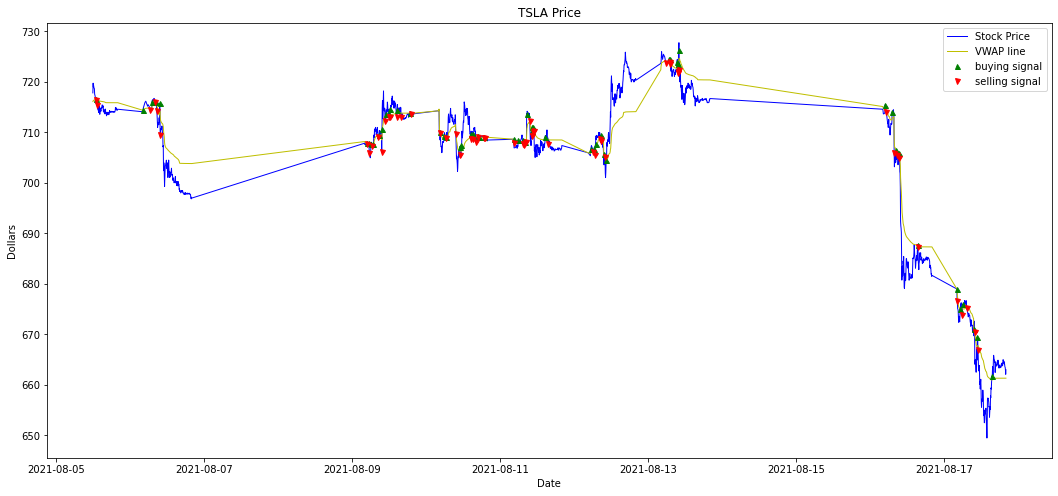

In [ ]:
#Buy and sell signals plot for Tesla (5-min interval)
VWAP_TSLA_Figure = signal_figure(df_TSLA, signals_TSLA, 'TSLA')
VWAP_Signal_TSLA = VWAP_TSLA_Figure.signal_figure()

In [ ]:
VWAP_Signal_TSLA.head(13)

,close,VWAP,signal,positions
date,,,,
2021-08-05 11:55:00,717.8400,716.1384,1.0,0.0
2021-08-05 12:00:00,719.7600,716.2083,1.0,0.0
2021-08-05 12:05:00,718.9900,716.3279,1.0,0.0
2021-08-05 12:10:00,719.2700,716.3695,1.0,0.0
2021-08-05 12:15:00,718.9000,716.3980,1.0,0.0
2021-08-05 12:20:00,718.7800,716.4210,1.0,0.0
2021-08-05 12:25:00,718.6600,716.4500,1.0,0.0
2021-08-05 12:30:00,717.5586,716.4685,1.0,0.0
2021-08-05 12:35:00,717.4100,716.4798,1.0,0.0


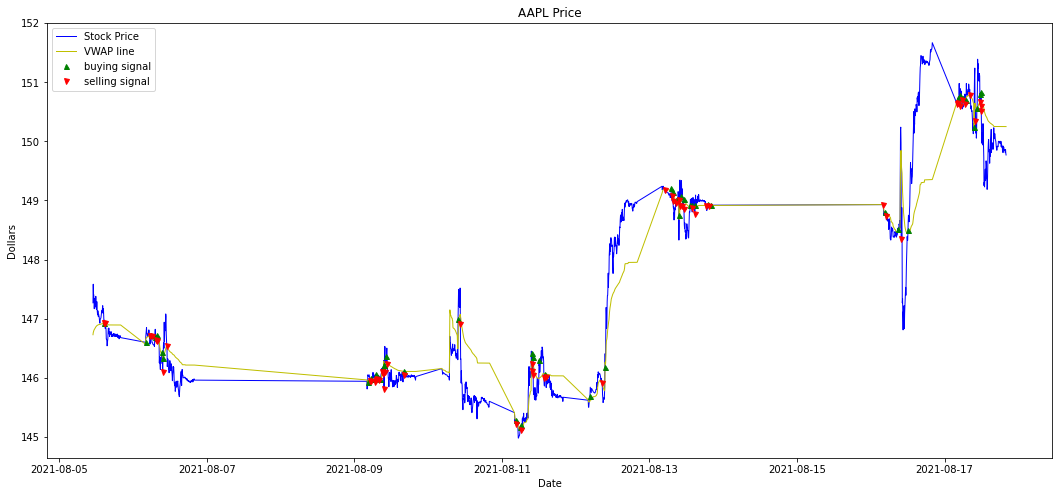

In [ ]:
#Buy and sell signals plot for Apple (5-min interval)
VWAP_AAPL_Figure = signal_figure(df_AAPL, signals_AAPL, 'AAPL')
VWAP_Signal_AAPL = VWAP_AAPL_Figure.signal_figure()

In [ ]:
VWAP_Signal_AAPL.head()

,close,VWAP,signal,positions
date,,,,
2021-08-05 11:00:00,147.2683,146.7282,1.0,0.0
2021-08-05 11:05:00,147.5828,146.7625,1.0,0.0
2021-08-05 11:10:00,147.4006,146.7789,1.0,0.0
2021-08-05 11:15:00,147.4074,146.7954,1.0,0.0
2021-08-05 11:20:00,147.2683,146.8072,1.0,0.0


# 3. Generate Return of Investment and Portfolio Flows (cash, holding and total)

In [ ]:
class portfolio:
  def __init__(self,data,topic,initial_capital=10000,max_buy=10000000,max_sell=10000000):
    self.data = data
    self.topic = topic
    self.initial_capital = initial_capital
    self.max_buy = max_buy
    self.max_sell = max_sell
  def portfolios(self):
    management = self.data
    prices = self.data['close']
    states = self.data['positions']
    states_buy = []
    states_sell = []
    cashes = []
    stocks = []
    holdings = []
    cash = self.initial_capital
    stock = 0
    holding = 0
    state = 0
    def buy(i,cash,stock,price):
      shares = cash // price #shares to buy in integer
      if shares<1:
        print('order %d: total cash %f, not enough to buy 1 share at price %f' % (i, cash, price))
      else:
        if shares>self.max_buy:
            buy_units = self.max_buy
        else:
            buy_units = shares
        cost = buy_units*price
        cash -= cost
        stock += buy_units
        holding = stock*price
        print('index %d: buy %d units at price %f, current cash %f, current stock %f,current holding %f' % (i, buy_units, price, cash, stock, holding))
      return cash, stock, holding   

    def sell(i,cash, stock,price):
      if stock == 0:
        print('index %d: cannot sell anything, currentstock 0' % (i))
        holding = 0
        
      else:
        if stock > self.max_sell:
          sell_units = self.max_sell
        else:
          sell_units = stock
          stock -=sell_units
          revenue = sell_units*price
          cash += revenue
          holding = stock*price
          print('index %d: sell %d units at price %f, current cash %f, current stock %f,current holding %f' % (i, sell_units, price, cash, stock, holding))
      return cash, stock, holding

    for i in range(0,management.shape[0]):
      state = states[i]
      price = prices[i]
      if state == 1:
        cash, stock, holding = buy(i, cash, stock, price)
        states_buy.append(i)
      elif state == -1:
        cash, stock, holding = sell(i,cash, stock, price)
        states_sell.append(i)
      cashes.append(cash)
      stocks.append(stock)
      holdings.append(holding)
    
    management['cash']=cashes
    management['stock']=stocks
    management['holding']=holdings
    management['total']=management['cash']+management['holding']
    management['roi']=(management['total']-self.initial_capital)/self.initial_capital
    fig, (ax1, ax2) = plt.subplots(2,1, sharey=False, figsize=(14,10))
    ax1.plot(management[['holding', 'cash', 'total']])
    ax1.legend(management[['holding', 'cash', 'total']])
    ax1.set_title("Visualization of " + self.topic + " Portfolio Flows")
    ax2.plot(management[['roi']])
    ax2.legend(management[['roi']])
    ax2.set_title(self.topic + " Return of Investment")
    plt.show()
    return management
 

index 12: cannot sell anything, currentstock 0
index 14: buy 13 units at price 716.529000, current cash 685.123000, current stock 13.000000,current holding 9314.877000
index 15: sell 13 units at price 715.361500, current cash 9984.822500, current stock 0.000000,current holding 0.000000
index 92: buy 13 units at price 714.500000, current cash 696.322500, current stock 13.000000,current holding 9288.500000
index 99: sell 13 units at price 714.500000, current cash 9984.822500, current stock 0.000000,current holding 0.000000
index 103: buy 13 units at price 716.000000, current cash 676.822500, current stock 13.000000,current holding 9308.000000
index 114: sell 13 units at price 716.000000, current cash 9984.822500, current stock 0.000000,current holding 0.000000
index 117: buy 13 units at price 716.000000, current cash 676.822500, current stock 13.000000,current holding 9308.000000
index 120: sell 13 units at price 714.330000, current cash 9963.112500, current stock 0.000000,current holdin

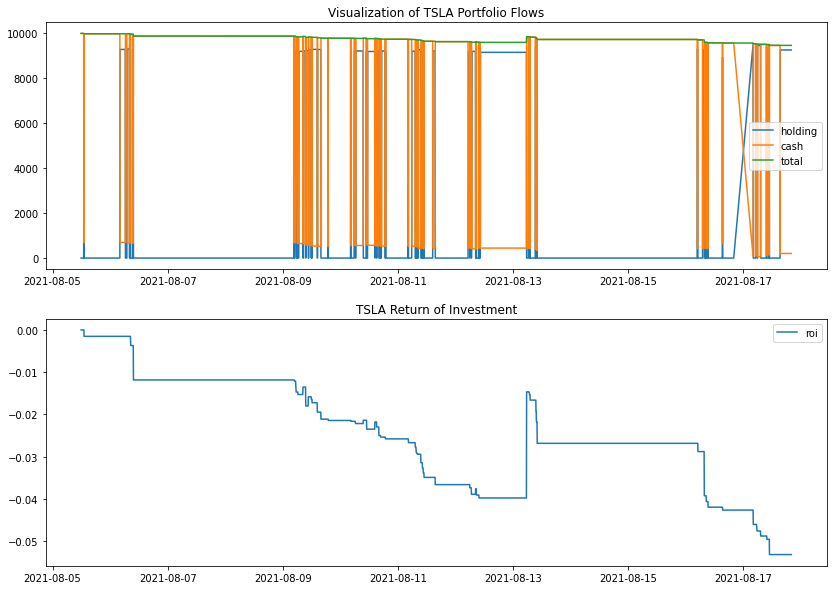

,close,VWAP,signal,positions,cash,stock,holding,total,roi
date,,,,,,,,,
2021-08-17 19:40:00,663.58,661.3342,1.0,0.0,204.9179,14.0,9263.66,9468.5779,-0.053142
2021-08-17 19:45:00,663.48,661.3344,1.0,0.0,204.9179,14.0,9263.66,9468.5779,-0.053142
2021-08-17 19:50:00,663.00,661.3348,1.0,0.0,204.9179,14.0,9263.66,9468.5779,-0.053142
2021-08-17 19:55:00,662.10,661.3349,1.0,0.0,204.9179,14.0,9263.66,9468.5779,-0.053142
2021-08-17 20:00:00,663.00,661.3354,1.0,0.0,204.9179,14.0,9263.66,9468.5779,-0.053142


In [ ]:
VWAP_TSLA_Portfolio = portfolio(VWAP_Signal_TSLA,'TSLA')
TSLA_Portfolio = VWAP_TSLA_Portfolio.portfolios()
TSLA_Portfolio.tail()

index 43: cannot sell anything, currentstock 0
index 44: buy 68 units at price 146.934600, current cash 8.447200, current stock 68.000000,current holding 9991.552800
index 47: sell 68 units at price 146.928900, current cash 9999.612400, current stock 0.000000,current holding 0.000000
index 108: buy 68 units at price 146.600000, current cash 30.812400, current stock 68.000000,current holding 9968.800000
index 121: sell 68 units at price 146.700000, current cash 10006.412400, current stock 0.000000,current holding 0.000000
index 124: buy 68 units at price 146.730000, current cash 28.772400, current stock 68.000000,current holding 9977.640000
index 126: sell 68 units at price 146.700000, current cash 10004.372400, current stock 0.000000,current holding 0.000000
index 132: buy 68 units at price 146.690000, current cash 29.452400, current stock 68.000000,current holding 9974.920000
index 136: sell 68 units at price 146.640000, current cash 10000.972400, current stock 0.000000,current holdin

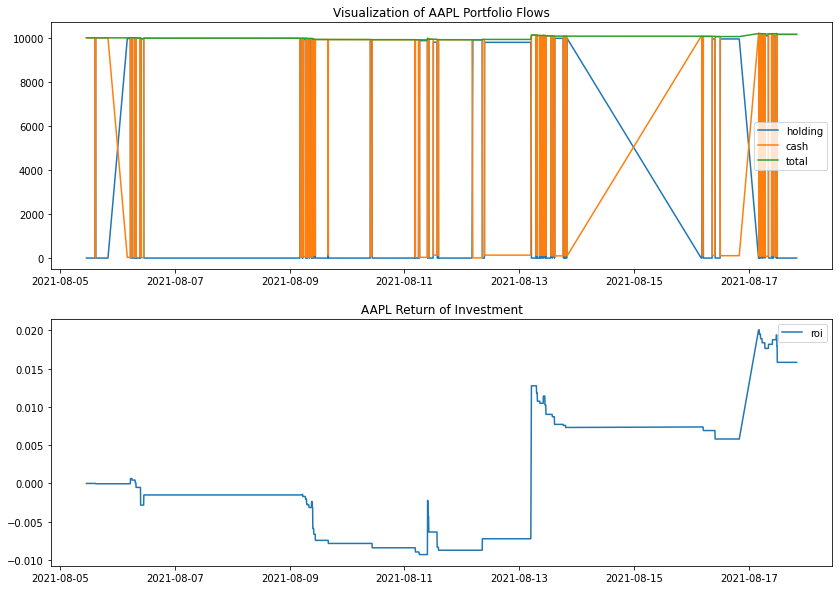

,close,VWAP,signal,positions,cash,stock,holding,total,roi
date,,,,,,,,,
2021-08-05 11:00:00,147.2683,146.7282,1.0,0.0,10000.0,0.0,0.0,10000.0,0.0
2021-08-05 11:05:00,147.5828,146.7625,1.0,0.0,10000.0,0.0,0.0,10000.0,0.0
2021-08-05 11:10:00,147.4006,146.7789,1.0,0.0,10000.0,0.0,0.0,10000.0,0.0
2021-08-05 11:15:00,147.4074,146.7954,1.0,0.0,10000.0,0.0,0.0,10000.0,0.0
2021-08-05 11:20:00,147.2683,146.8072,1.0,0.0,10000.0,0.0,0.0,10000.0,0.0


In [ ]:
VWAP_AAPL_Portfolio = portfolio(VWAP_Signal_AAPL,'AAPL')
AAPL_Portfolio = VWAP_AAPL_Portfolio.portfolios()
AAPL_Portfolio.head()